## GEORGIOS KOUTROUMPIS, AEM 9668
### ECE AUTh, 2022
### Computational Intelligence
#### Project 4, RBF

In [ ]:
# Imports
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.datasets import boston_housing
from keras import layers
from keras.layers import Layer
from keras.initializers import Initializer, Constant
from sklearn.cluster import KMeans
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define custom RBF layer
class RBFLayer(Layer): 

  # Initialization
  def __init__(self, output_dim, initializer, b=1.0, **kwargs):    
    self.output_dim = output_dim 
    self.b = b
    self.initializer = initializer
    super(RBFLayer, self).__init__(**kwargs)

  def build(self, input_shape): 
    self.c = self.add_weight(name = 'c', 
      shape=(self.output_dim, input_shape[1]), 
      initializer = self.initializer, trainable = False) 

    # Find the maximum distance between the centers
    d_max = 0
    for i in range(0, self.output_dim):
      for j in range(0, self.output_dim):
          d = np.linalg.norm(self.c[i] - self.c[j])
          if d > d_max:
              d_max = d

    # Compute sigma and then beta
    sigma = d_max / np.sqrt(2 * self.output_dim)
    self.b = np.ones(self.output_dim) / (2 * (sigma ** 2))

    super(RBFLayer, self).build(input_shape)

  def call(self, input_data): 
    C = K.expand_dims(self.c)
    H = K.transpose(C-K.transpose(input_data))
    return K.exp(-self.b * K.sum(H**2, axis=1))

  def compute_output_shape(self, input_shape):
      return (input_shape[0], self.output_dim)

class InitCentersKMeans(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]
        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [ ]:
# Load data
(X_train, Y_train), (X_test, Y_test) = boston_housing.load_data(test_split=0.25)

# Normalize data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

# Split data so the KMeans initialization can work
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

65536/57026 [==================================] - 0s 0us/step


In [ ]:
# Functions for the R^2 and MSE metrics
def Rsquare(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

# Function that plots loss, R^2 and RMSE plots for training
def plot_metrics(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for Rsquare
  plt.plot(history.history['Rsquare'])
  plt.plot(history.history['val_Rsquare'])
  plt.title('model Rsquare error')
  plt.ylabel('Rsquare')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for rmse
  plt.plot(history.history['rmse'])
  plt.plot(history.history['val_rmse'])
  plt.title('model rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Function that builds and trains an RBF network (with an additional hidden
# layer), using a @rbf_neurons size (neurons #) for the RBF layer
def build_RBF_model(X_train, Y_train, X_val, Y_val, rbf_neurons, input_shape):

  model = Sequential()
  model.add(RBFLayer(rbf_neurons, initializer=InitCentersKMeans(X_train), 
                      input_shape=input_shape))
  model.add(Dense(128))
  model.add(Dense(1))

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                loss=mse, 
                metrics=[Rsquare,
                         tf.keras.metrics.RootMeanSquaredError("rmse")])
  history = model.fit(X_train, Y_train, epochs=100, 
                      validation_data=(X_val,Y_val),verbose=0)
  return model, history

In [ ]:
# Get num of train data
train_data = X_train.shape[0]

# Get number of neurons for the RBF layer of each model
rbf_neurons_vals = [0.1*train_data, 0.5*train_data, 0.9*train_data]

# Get input shape
input_shape = (X_train.shape[1],)

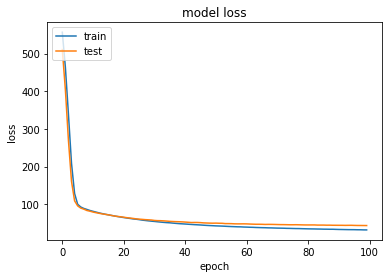

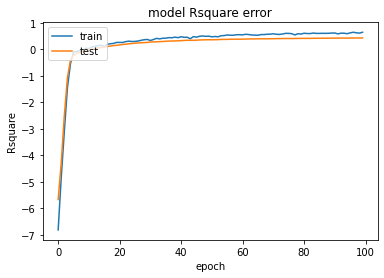

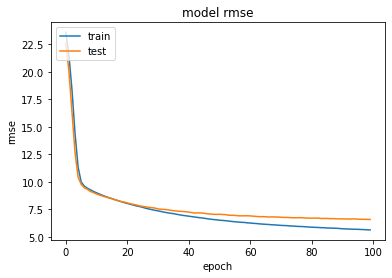

4/4 [==============================] - 0s 5ms/step - loss: 31.3752 - Rsquare: 0.5529 - rmse: 5.6014

  Results on test data, using an RBF Layer of 30 neurons

  MSE     : 31.37523651123047

  R^2     : 0.5528824329376221

  RMSE    : 5.601360321044922
  


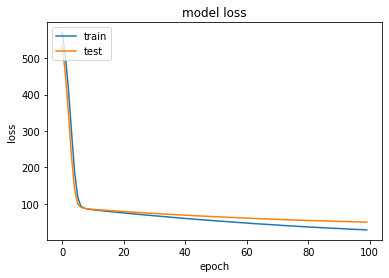

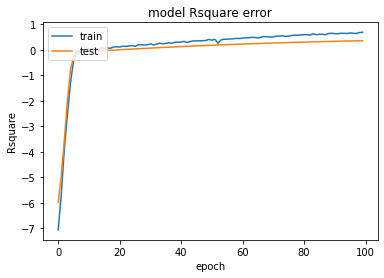

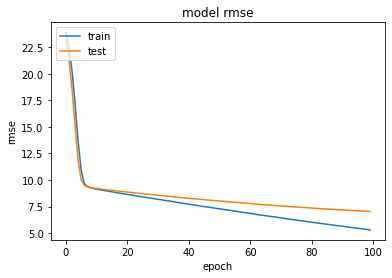

4/4 [==============================] - 0s 4ms/step - loss: 47.5509 - Rsquare: 0.3381 - rmse: 6.8957

  Results on test data, using an RBF Layer of 151 neurons

  MSE     : 47.550865173339844

  R^2     : 0.3380654454231262

  RMSE    : 6.8957133293151855
  


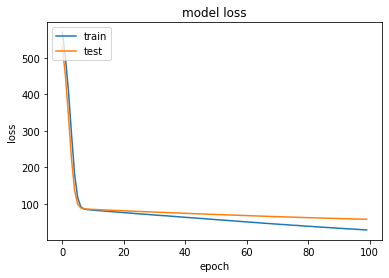

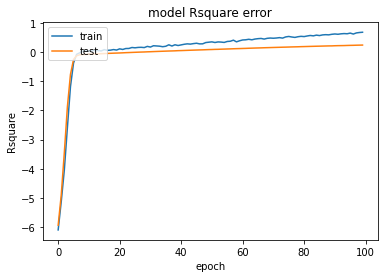

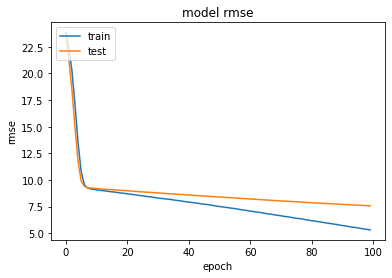

4/4 [==============================] - 0s 7ms/step - loss: 57.4978 - Rsquare: 0.2001 - rmse: 7.5827

  Results on test data, using an RBF Layer of 272 neurons

  MSE     : 57.497833251953125

  R^2     : 0.20006626844406128

  RMSE    : 7.582732677459717
  


In [ ]:
# Train each model with the different number of neurons in RBF layer

for rbf_neurons in rbf_neurons_vals:
  rbf_neurons = int(rbf_neurons)
  model, history = build_RBF_model(X_train, Y_train, X_val, Y_val,
                                   rbf_neurons, input_shape)
  
  plot_metrics(history)

  results = model.evaluate(X_test, Y_test)

  print(f"""
  Results on test data, using an RBF Layer of {rbf_neurons} neurons\n
  MSE     : {results[0]}\n
  R^2     : {results[1]}\n
  RMSE    : {results[2]}
  """)
